In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
import itertools
import warnings
warnings.filterwarnings('ignore')

In [43]:
# Step 1: Data Preparation
# Load OHLC data into a DataFrame, assuming columns are 'Date', 'Open', 'High', 'Low', and 'Close'
df = pd.read_csv('GOLD_DATA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample to daily frequency and fill missing values
df = df.resample('D').ffill()

In [44]:
df

,Close,Open,High,Low
Date,,,,
2008-01-01,113.0520,113.4020,113.6990,112.3770
2008-01-02,122.3060,125.7200,126.0010,121.6370
2008-01-03,122.3060,125.7200,126.0010,121.6370
2008-01-04,118.2780,120.1030,120.4900,116.7460
2008-01-05,113.3620,115.2940,115.5600,113.0420
...,...,...,...,...
2022-11-27,218.2969,219.9041,219.9480,215.7610
2022-11-28,218.2969,219.9041,219.9480,215.7610
2022-11-29,218.2969,219.9041,219.9480,215.7610


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5449 entries, 2008-01-01 to 2022-12-01
Freq: D
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5449 non-null   float64
 1   Open    5449 non-null   float64
 2   High    5449 non-null   float64
 3   Low     5449 non-null   float64
dtypes: float64(4)
memory usage: 212.9 KB


In [46]:
df.describe()

,Close,Open,High,Low
count,5449.000000,5449.000000,5449.000000,5449.000000
mean,168.399828,168.382465,169.492863,167.239209
std,31.186955,31.186489,31.387050,30.941195
min,92.435000,91.127000,95.095000,91.114000
25%,148.504400,148.556600,149.509000,147.665800
50%,161.352800,161.451600,162.202100,160.660800
75%,197.334300,197.806200,198.997800,196.538100
max,241.734000,242.398400,244.200000,238.437500


In [47]:
print(df.head())  # Display the first few rows of the data

              Close     Open     High      Low
Date                                          
2008-01-01  113.052  113.402  113.699  112.377
2008-01-02  122.306  125.720  126.001  121.637
2008-01-03  122.306  125.720  126.001  121.637
2008-01-04  118.278  120.103  120.490  116.746
2008-01-05  113.362  115.294  115.560  113.042


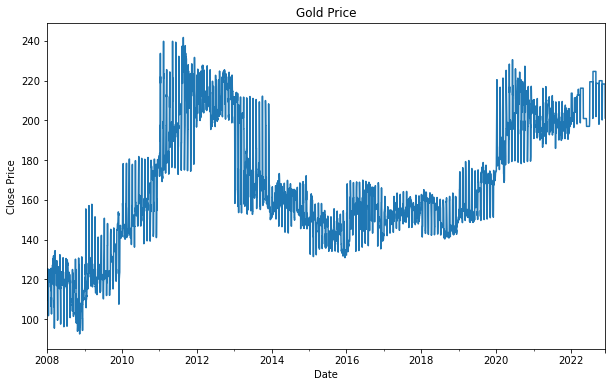

In [48]:
# Step 2: Exploratory Data Analysis (EDA)
# Perform EDA and visualize the time series data

df['Close'].plot(figsize=(10, 6))  # Plot the closing prices
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Gold Price')
plt.show()

In [49]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

In [50]:
#Seasonal Decomposition
decomposition = seasonal_decompose(train_data['Close'], model='multiplicative', period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

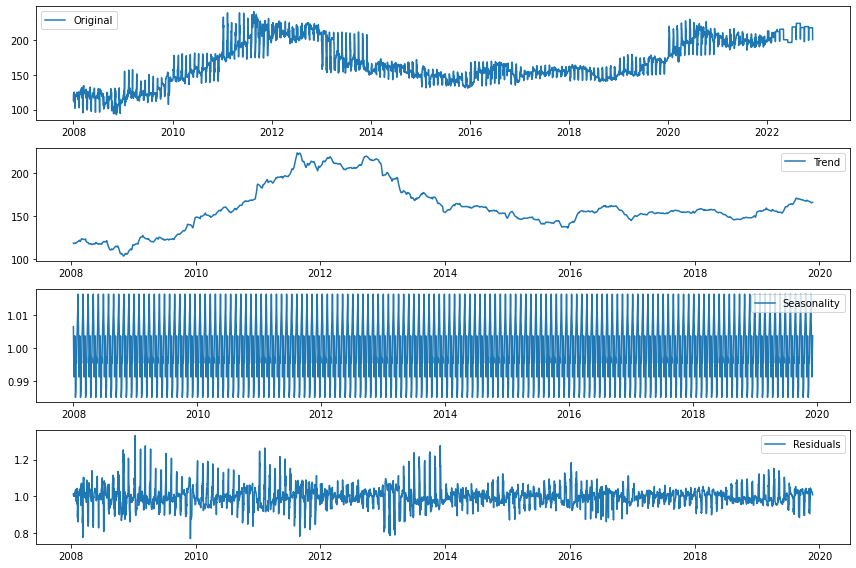

In [51]:
#Plot the decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuals, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [52]:
# Step 3: Feature Engineering
# Extract additional features or transformations to improve the model
df['Returns'] = df['Close'].pct_change()  # Calculate daily returns
df['Lagged_Returns'] = df['Returns'].shift()  # Create lagged returns
# ... (additional feature engineering if necessary)

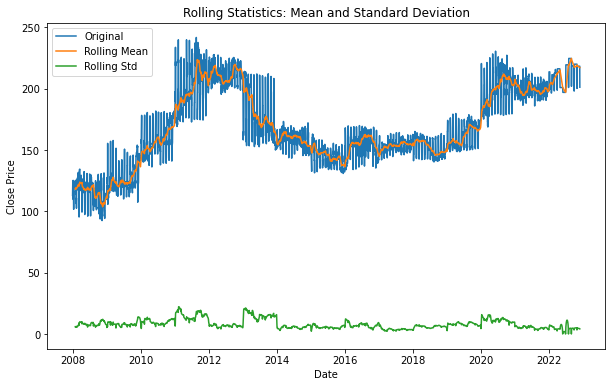

In [53]:
# Step 4: Check for Stationarity using Rolling Statistics
rolling_mean = df['Close'].rolling(window=30).mean()
rolling_std = df['Close'].rolling(window=30).std()

# Plot rolling statistics
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Rolling Statistics: Mean and Standard Deviation')
plt.legend()
plt.show()

In [54]:
# Condition check for stationarity using Rolling Statistics
rolling_p_value = adfuller(df['Close'].rolling(window=30).mean().dropna())[1]

if rolling_p_value > 0.05:
    print("The series is likely non-stationary based on rolling statistics.")
else:
    print("The series is likely stationary based on rolling statistics.")

The series is likely non-stationary based on rolling statistics.


In [55]:
# Step 5: Check for Stationarity using Dickey-Fuller Test
adf_result = adfuller(df['Close'])
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'{key}: {value}')

ADF Statistic: -1.280982218281603
p-value: 0.6378274418222224
Critical Values:
1%: -3.4315581999292024
5%: -2.862073902727173
10%: -2.567054195520633


In [56]:
# Condition check for stationarity using Dickey-Fuller Test
if p_value > 0.05:
    print("The series is likely non-stationary based on the Dickey-Fuller test.")
else:
    print("The series is likely stationary based on the Dickey-Fuller test.")

The series is likely non-stationary based on the Dickey-Fuller test.


In [57]:
# Step 6: Make the Data Stationary
df['Stationary_Close'] = df['Close'].diff()
df['Stationary_Close'].dropna(inplace=True)

In [58]:
# Step 7: Check for Stationarity of Differenced Data using Rolling Statistics
rolling_mean_diff = df['Stationary_Close'].rolling(window=30).mean()
rolling_std_diff = df['Stationary_Close'].rolling(window=30).std()

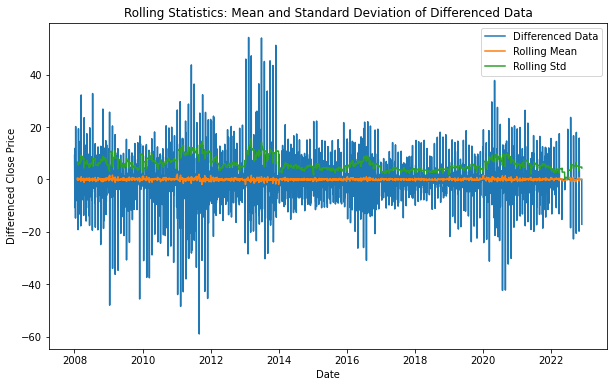

In [59]:
# Plot rolling statistics of differenced series
plt.figure(figsize=(10, 6))
plt.plot(df['Stationary_Close'], label='Differenced Data')
plt.plot(rolling_mean_diff, label='Rolling Mean')
plt.plot(rolling_std_diff, label='Rolling Std')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.title('Rolling Statistics: Mean and Standard Deviation of Differenced Data')
plt.legend()
plt.show()

In [60]:
# Condition check for stationarity of differenced series using Rolling Statistics
rolling_mean_diff_p_value = adfuller(rolling_mean_diff.dropna())[1]

if rolling_mean_diff_p_value > 0.05:
    print("The differenced series is likely non-stationary based on rolling mean statistics.")
else:
    print("The differenced series is likely stationary based on rolling mean statistics.")

The differenced series is likely stationary based on rolling mean statistics.


In [61]:
# Step 8: Check for Stationarity using Dickey-Fuller Test on Differenced Data
stationary_close = df['Stationary_Close'].dropna()  # Remove rows with missing values

adf_result_diff = adfuller(stationary_close)
adf_statistic_diff = adf_result_diff[0]
p_value_diff = adf_result_diff[1]
critical_values_diff = adf_result_diff[4]

print('ADF Statistic (Differenced Data):', adf_statistic_diff)
print('p-value (Differenced Data):', p_value_diff)
print('Critical Values (Differenced Data):')
for key, value in critical_values_diff.items():
    print(f'{key}: {value}')

ADF Statistic (Differenced Data): -19.268094906604773
p-value (Differenced Data): 0.0
Critical Values (Differenced Data):
1%: -3.4315581999292024
5%: -2.862073902727173
10%: -2.567054195520633


In [62]:
# Condition check for stationarity of differenced series using Dickey-Fuller Test
if p_value_diff > 0.05:
    print("The differenced series is likely non-stationary based on the Dickey-Fuller test.")
else:
    print("The differenced series is likely stationary based on the Dickey-Fuller test.")


The differenced series is likely stationary based on the Dickey-Fuller test.


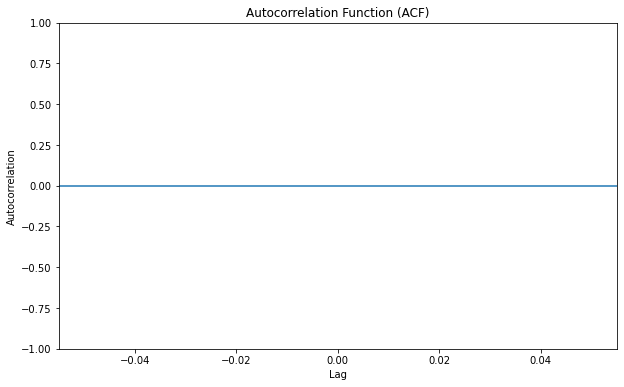

In [63]:
# Step 9: Plot Autocorrelation and Partial Autocorrelation Functions
# Plot Autocorrelation Function (ACF)
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(df['Stationary_Close'], ax=ax, lags=30)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

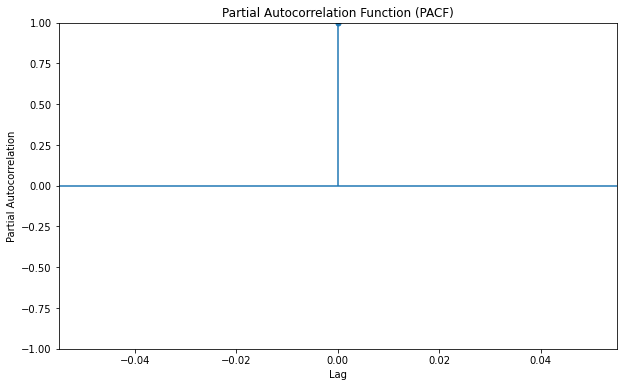

In [64]:
# Plot Partial Autocorrelation Function (PACF)
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df['Stationary_Close'], ax=ax, lags=30)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [65]:
# Step 10: Split the Data into Training and Test Sets
train_data = df['Stationary_Close'].iloc[:int(0.8 * len(df))]
test_data = df['Stationary_Close'].iloc[int(0.8 * len(df)):]


print("Training data size:", len(train_data))
print("Test data size:", len(test_data))

Training data size: 4359
Test data size: 1090


In [66]:
# Step 11: Select the Best ARIMA Parameters using Grid Search
# Define range of values for p, d, q
p_values = range(0, 3)  # example range
d_values = range(0, 3)  # example range
q_values = range(0, 3)  # example range

# Initialize variables
best_aic = float('inf')
best_order = None

# Grid search
for p, d, q in itertools.product(p_values, d_values, q_values):
    order = (p, d, q)
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_aic:
            best_aic = aic
            best_order = order
    except:
        continue

# Select the best order
p_arima, d_arima, q_arima = best_order


In [67]:
print(p_arima)
print(d_arima)
print(q_arima)

2
0
1


In [68]:
# Step 12: Fit the ARIMA Model
model_arima = ARIMA(train_data, order=(p_arima, d_arima, q_arima))
model_fit_arima = model_arima.fit()

In [69]:
# Step 13: Forecast Future Prices with ARIMA

forecast_arima = model_fit_arima.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

In [70]:
# Step 14: Evaluate the ARIMA Model
residuals_arima = test_data - forecast_arima

mae_arima = np.mean(np.abs(residuals_arima))
mse_arima = np.mean(residuals_arima**2)
rmse_arima = np.sqrt(mse_arima)
r2_arima = r2_score(test_data, forecast_arima)

print('ARIMA Model Evaluation:')
print('Mean Absolute Error (MAE):', mae_arima)
print('Mean Squared Error (MSE):', mse_arima)
print('Root Mean Squared Error (RMSE):', rmse_arima)
print('R-squared Score:', r2_arima)

ARIMA Model Evaluation:
Mean Absolute Error (MAE): 2.633760928825041
Mean Squared Error (MSE): 35.290550302539955
Root Mean Squared Error (RMSE): 5.940585013493196
R-squared Score: 0.00028250158910525514


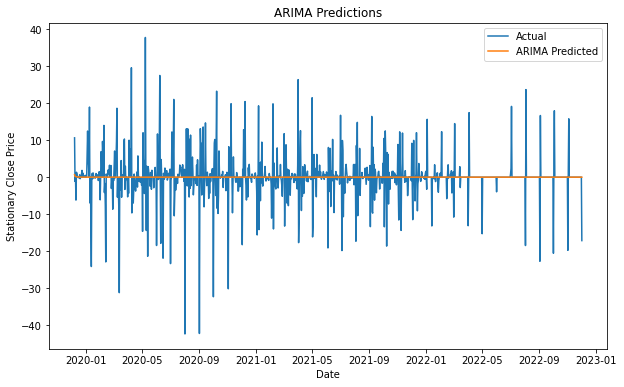

In [71]:
# Step 15: Visualize the Predictions for ARIMA
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, forecast_arima, label='ARIMA Predicted')
plt.xlabel('Date')
plt.ylabel('Stationary Close Price')
plt.title('ARIMA Predictions')
plt.legend()
plt.show()

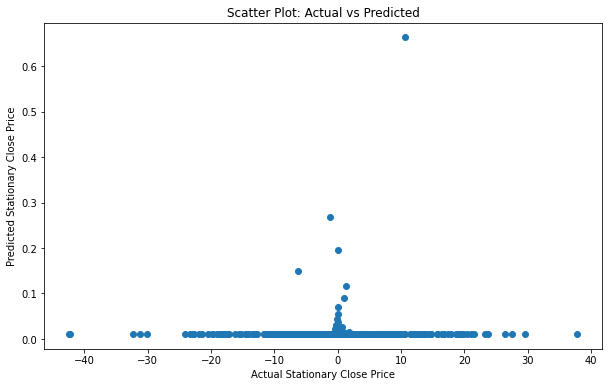

In [72]:
# Step 16: Scatter plot of price_change vs model price_change
plt.figure(figsize=(10, 6))
plt.scatter(test_data, forecast_arima)
plt.xlabel('Actual Stationary Close Price')
plt.ylabel('Predicted Stationary Close Price')
plt.title('Scatter Plot: Actual vs Predicted')
plt.show()

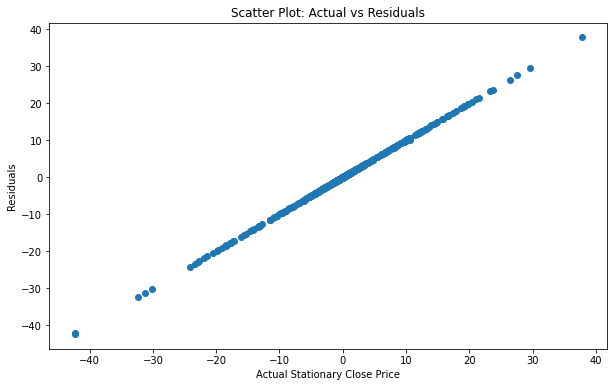

In [73]:
# Step 17: Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(test_data, residuals_arima)
plt.xlabel('Actual Stationary Close Price')
plt.ylabel('Residuals')
plt.title('Scatter Plot: Actual vs Residuals')
plt.show()

In [74]:
# Step 18: Select the Best SARIMA Parameters using Grid Search
p_values = range(0, 2)  # example range
d_values = range(0, 2)  # example range
q_values = range(0, 2)  # example range
P_values = range(0, 2)  # example range
D_values = range(0, 2)  # example range
Q_values = range(0, 2)  # example range
s_values = [7]  # example value

best_aic = float('inf')
best_order = None
best_seasonal_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for s in s_values:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, s)
                            try:
                                model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
                                model_fit = model.fit()
                                aic = model_fit.aic
                                if aic < best_aic:
                                    best_aic = aic
                                    best_order = order
                                    best_seasonal_order = seasonal_order
                            except:
                                continue

p_sarima, d_sarima, q_sarima = best_order
P_sarima, D_sarima, Q_sarima, s_sarima = best_seasonal_order

In [75]:
print(p_sarima)
print(d_sarima)
print(q_sarima)
print(P_sarima)
print(D_sarima)
print(Q_sarima)
print(s_sarima)


1
0
1
0
0
1
7


In [76]:
# Step 19: Fit the SARIMA Model
model_sarima = SARIMAX(train_data, order=(p_sarima, d_sarima, q_sarima),
                       seasonal_order=(P_sarima, D_sarima, Q_sarima, s_sarima))
model_fit_sarima = model_sarima.fit()

In [77]:
# Step 20: Forecast Future Prices using SARIMA Model
forecast_sarima = model_fit_sarima.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

In [78]:
# Step 21: Evaluate the SARIMA Model
residuals_sarima = test_data - forecast_sarima

mae_sarima = np.mean(np.abs(residuals_sarima))
mse_sarima = np.mean(residuals_sarima**2)
rmse_sarima = np.sqrt(mse_sarima)
r2_sarima = r2_score(test_data, forecast_sarima)

print('SARIMA Model Evaluation:')
print('Mean Absolute Error (MAE):', mae_sarima)
print('Mean Squared Error (MSE):', mse_sarima)
print('Root Mean Squared Error (RMSE):', rmse_sarima)
print('R-squared Score:', r2_sarima)

SARIMA Model Evaluation:
Mean Absolute Error (MAE): 2.630943733311527
Mean Squared Error (MSE): 35.30328316408123
Root Mean Squared Error (RMSE): 5.941656600989427
R-squared Score: -7.819736227210328e-05


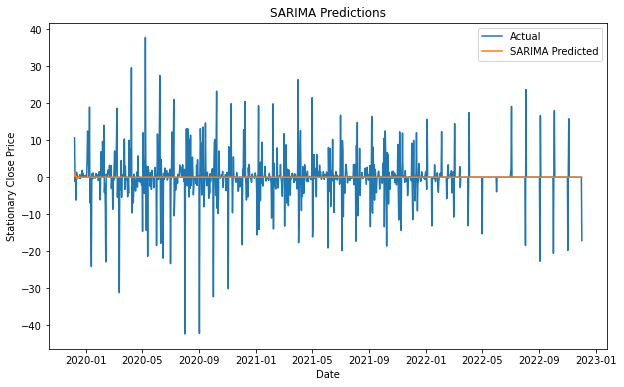

In [79]:
# Step 22: Visualize the Predictions for SARIMA
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, forecast_sarima, label='SARIMA Predicted')
plt.xlabel('Date')
plt.ylabel('Stationary Close Price')
plt.title('SARIMA Predictions')
plt.legend()
plt.show()

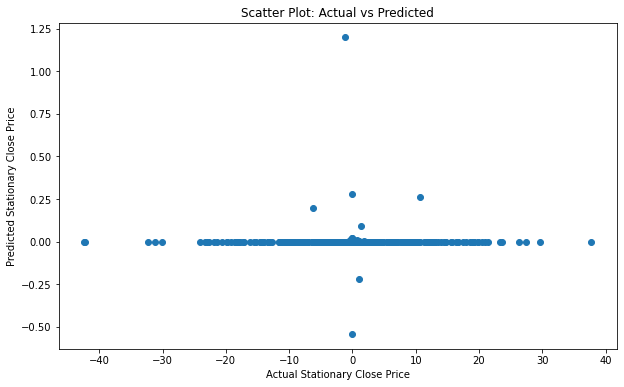

In [80]:
# Step 23: Scatter plot of price_change vs model price_change
plt.figure(figsize=(10, 6))
plt.scatter(test_data, forecast_sarima)
plt.xlabel('Actual Stationary Close Price')
plt.ylabel('Predicted Stationary Close Price')
plt.title('Scatter Plot: Actual vs Predicted')
plt.show()


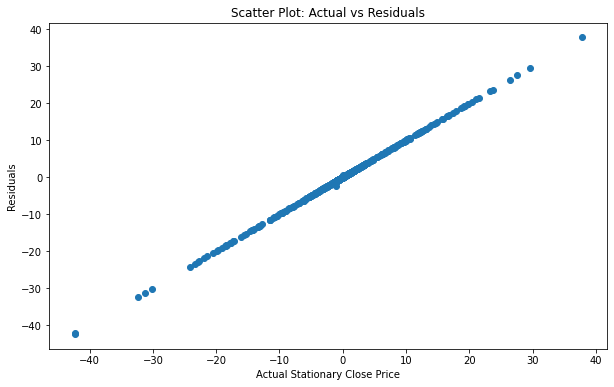

In [81]:
# Step 24: Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(test_data, residuals_sarima)
plt.xlabel('Actual Stationary Close Price')
plt.ylabel('Residuals')
plt.title('Scatter Plot: Actual vs Residuals')
plt.show()